### Mixture of Experts (MoE) Transformer with Llama4 type model 

Author: Tirth Shah  
Inspired by: https://github.com/FareedKhan-dev/train-llama4

#### Import Required Libraries and Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Import our custom modules
from model import MoETransformer, ModelConfig
from prepare_data import CharDataset, TinyStoriesDataset, sample_alice_text
from train import TrainModel, TrainConfig
import utils as utils

/Users/tirthshah/miniforge3/envs/moe-experiments/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set random seed for reproducibility

In [2]:
torch.manual_seed(42)

#### Prepare Dataset

In [3]:
dataset_tag = 'sample_alice'  # Choose dataset: 'sample_alice' or 'tiny_stories'

if dataset_tag == 'sample_alice':
    #--------- Sample text from Alice's Adventures in Wonderland ---------#
    # This is a small excerpt to keep the dataset manageable for demonstration purposes.

    block_size = 64 # Define the block size for the dataset
    dataset = CharDataset(text=sample_alice_text, block_size=block_size) # Create dataset

elif dataset_tag == 'tiny_stories':
    #--------- Tiny stories dataset ---------#
    # This dataset is a collection of short stories, which can be used for training language models.

    block_size = 64 # Define the block size for the dataset
    dataset = TinyStoriesDataset(block_size=block_size, max_samples=100000)  # Load the dataset

else:
    raise ValueError("Invalid dataset_tag. Choose 'sample_alice' or 'tiny_stories'.")

#### Initialize MoE Transformer Model

In [4]:
# Model configuration
model_config = ModelConfig(
    dataset_tag=dataset_tag,
    d_model=128, 
    n_layers=3, # 4
    n_heads=4,
    block_size=block_size,
    vocab_size=dataset.tokenizer.vocab_size,
    rms_norm_eps=1e-5,
    rope_theta=10000.0,
    num_local_experts=4,
    num_experts_per_tok=2,
    intermediate_size_expert=256,
    intermediate_size_shared=256
)

# Initialize the model
model = MoETransformer(config=model_config)
model = model.to(model.config.device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model initialized successfully!
Total parameters: 1,682,432
Trainable parameters: 1,682,432


#### Train the Model

Setting up training configuration

In [5]:
train_config = TrainConfig(
    learning_rate=5e-4,
    batch_size=16,
    epochs=2, # Set to 3000 for actual training
    print_interval=300,
    test_split=0.1
)

train_model = TrainModel(
    train_config=train_config,
    model=model,
    dataset=dataset,
)

Training the model

Starting training...


100%|██████████| 2/2 [00:03<00:00,  1.63s/it]

  Epoch 2/2, Loss: 3.5962


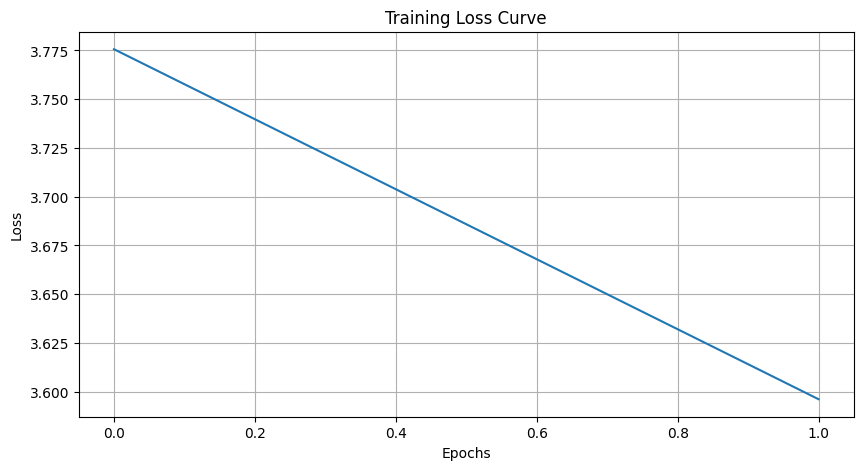

Training completed.
Final training loss: 3.5962


In [6]:
train_model.train()

print(f"Final training loss: {train_model.train_losses[-1]:.4f}")

Calculating test loss

In [7]:
test_loss = train_model.test_loss()

print(f"Test loss: {test_loss:.4f}")

Test loss: 3.4383


#### Save the Model

In [8]:
utils.save_model(
    train_obj=train_model,
    path="./saved_models/try.pth",
)

Model saved to ./saved_models/try.pth


#### Generate some text using the trained model

In [9]:
model.generate(
    seed_text="Alice", # "Once upon a time",
    tokenizer=dataset.tokenizer,
    max_new_tokens=model_config.block_size,
)

Generation loop finished.


"Alicetr-p,l,'?AApmktnsf?Anuk\ndav,f.shusSWR'?w-\ncbh:luhWk?'p'glf fi:t\n"